In [1]:
import sys
import warnings
import platform
import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau
from scipy.stats import rankdata
from multiprocessing import Pool
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google Drive'
    cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
else:
    base_FP = '/data'
    cpuserver_data_FP = '/data'
sys.path.append(base_FP + '/python_modules')

#hydroAI libs
import HydroAI.Data as hData
import HydroAI.Plot as hPlot

warnings.filterwarnings("ignore")

In [2]:
# load the data
data_path = cpuserver_data_FP+'/WORK/DATASETS/GLOBAL/CMIP6/0. OVERALL/DATA/'
file_list = hData.get_file_list(data_path, 'nc')
print(file_list)

['/data/WORK/DATASETS/GLOBAL/CMIP6/0. OVERALL/DATA/CMIP6_HIST_r1i1p1f1_1.00_005D_1970_2014.nc', '/data/WORK/DATASETS/GLOBAL/CMIP6/0. OVERALL/DATA/CMIP6_SSP126_r1i1p1f1_1.00_005D_2016_2100.nc', '/data/WORK/DATASETS/GLOBAL/CMIP6/0. OVERALL/DATA/CMIP6_SSP245_r1i1p1f1_1.00_005D_2016_2100.nc', '/data/WORK/DATASETS/GLOBAL/CMIP6/0. OVERALL/DATA/CMIP6_SSP585_r1i1p1f1_1.00_005D_2016_2100.nc']


In [3]:
hData.get_nc_variable_names_units(file_list[0]);
lai_detrend = hData.get_variable_from_nc(file_list[0], 'lai_detrend')
lat = hData.get_variable_from_nc(file_list[0], 'lat')
lon = hData.get_variable_from_nc(file_list[0], 'lon')
lon, lat = np.meshgrid(lon, lat)

print(lai_detrend.shape)
lai_detrend = np.transpose(lai_detrend, (2, 1, 0))
print(lai_detrend.shape)

dim1,dim2,dim3 = lai_detrend.shape

+--------------+----------------------------------------------------------+-----------------------+
| Name         | Long Name                                                | Units                 |
+==============+==========================================================+=======================+
| lat          | latitude                                                 | degrees_north         |
+--------------+----------------------------------------------------------+-----------------------+
| lon          | longitude                                                | degrees_east          |
+--------------+----------------------------------------------------------+-----------------------+
| time         | time                                                     | days since 0000-01-01 |
+--------------+----------------------------------------------------------+-----------------------+
| mrso_prctile | Ensemble Mean of Total Soil Moisture Percentile for HIST | %                     |


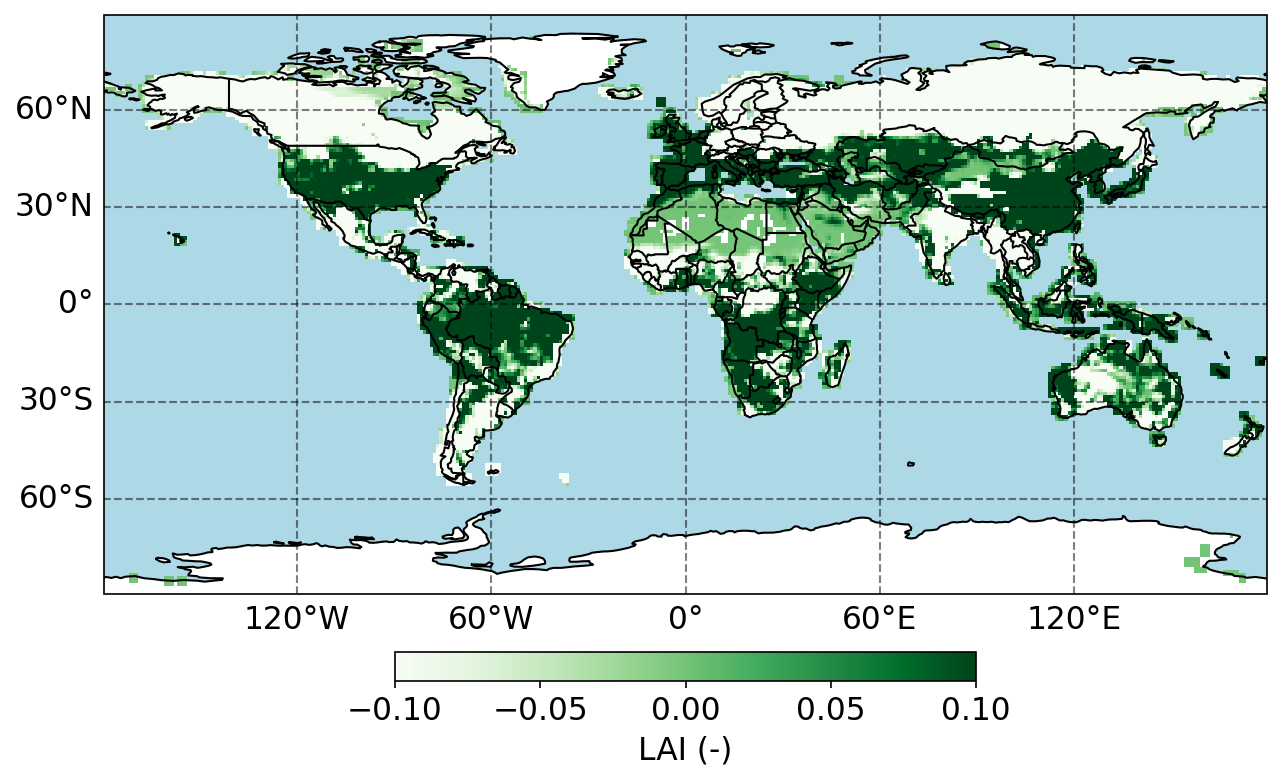

In [4]:
# check the data
target = lai_detrend[:,:,100]
hPlot.plot_map(lon, lat, target, np.min(target), np.max(target), plot_title='lai detrend', label_title='LAI (-)', cmap='Greens', projection='PlateCarree');

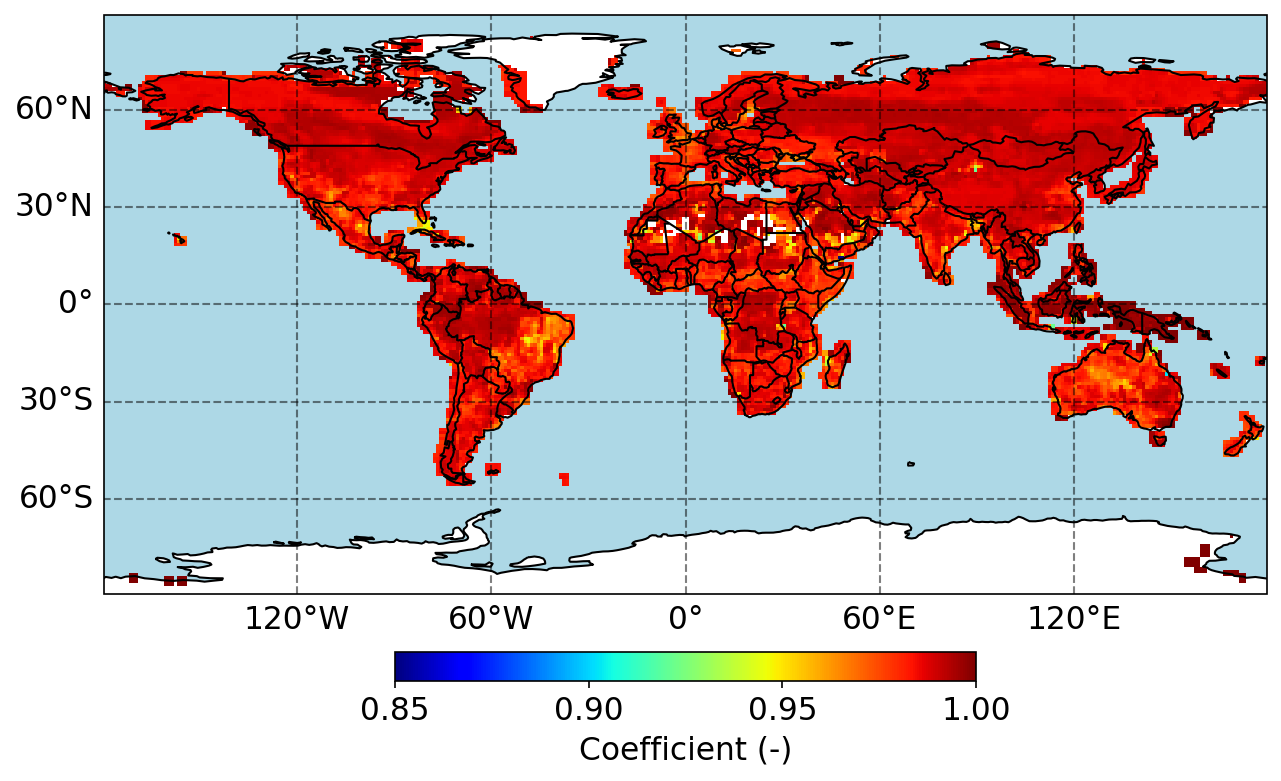

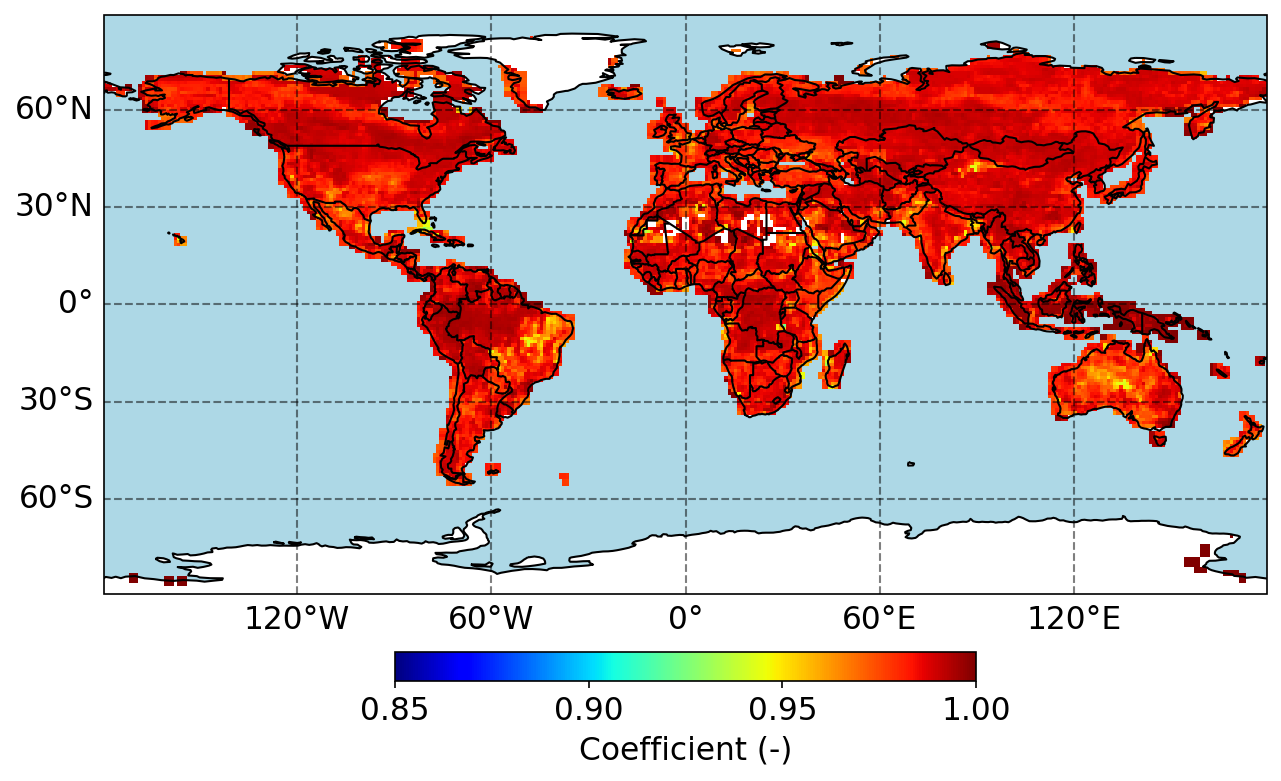

In [5]:
def generate_win_lag_data(data, t, win_size, lag_size):
    d1 = data[:, :, t-win_size+lag_size:t]
    d2 = data[:, :, t-win_size:t-lag_size]

    return d1, d2

def pearson_1d_test(x1, x2):
    # Step 1: Center the data (subtract the mean)
    mean_x1 = np.mean(x1)
    mean_x2 = np.mean(x2)
    x1_centered = x1 - mean_x1
    x2_centered = x2 - mean_x2
    
    # Step 2: Calculate the covariance between x1 and x2
    covariance = np.sum(x1_centered * x2_centered)
    
    # Step 3: Calculate the standard deviations of x1 and x2
    std_x1 = np.sqrt(np.sum(x1_centered ** 2))
    std_x2 = np.sqrt(np.sum(x2_centered ** 2))
    
    # Step 4: Calculate the Pearson correlation coefficient
    pearson_corr = covariance / (std_x1 * std_x2)

    return pearson_corr

def spearman_1d_test(x1, x2):
    # Step 1: Rank the data
    x1_ranked = np.argsort(np.argsort(x1))
    x2_ranked = np.argsort(np.argsort(x2))
    
    # Step 2: Center the ranked data (subtract the mean rank)
    mean_x1_ranked = np.mean(x1_ranked)
    mean_x2_ranked = np.mean(x2_ranked)
    x1_centered = x1_ranked - mean_x1_ranked
    x2_centered = x2_ranked - mean_x2_ranked
    
    # Step 3: Calculate the covariance between the ranked x1 and x2
    covariance = np.sum(x1_centered * x2_centered)
    
    # Step 4: Calculate the standard deviations of the ranked x1 and x2
    std_x1 = np.sqrt(np.sum(x1_centered ** 2))
    std_x2 = np.sqrt(np.sum(x2_centered ** 2))
    
    # Step 5: Calculate the Spearman correlation coefficient
    spearman_corr = covariance / (std_x1 * std_x2)
    
    return spearman_corr

def pearson_3d(d1, d2):
    # Step 1: Count the number of non-NaN values along the z-axis
    valid_counts = np.sum(~np.isnan(d1) & ~np.isnan(d2), axis=2)
    
    # Step 2: Center the data (subtract the mean along the z-axis)
    mean_d1 = np.nanmean(d1, axis=2, keepdims=True)
    mean_d2 = np.nanmean(d2, axis=2, keepdims=True)
    d1_centered = d1 - mean_d1
    d2_centered = d2 - mean_d2
    
    # Step 3: Calculate the covariance between x1 and x2 along the z-axis
    covariance = np.einsum('ijk,ijk->ij', d1_centered, d2_centered)
    
    # Step 4: Calculate the standard deviations of x1 and x2 along the z-axis
    std_d1 = np.sqrt(np.einsum('ijk,ijk->ij', d1_centered, d1_centered))
    std_d2 = np.sqrt(np.einsum('ijk,ijk->ij', d2_centered, d2_centered))
    
    # Step 5: Calculate the Pearson correlation coefficients
    pearson_corrs = covariance / (std_d1 * std_d2)
    
    # Step 6: Set correlation to NaN where the number of valid values is less than 30
    pearson_corrs[valid_counts < 30] = np.nan

    return pearson_corrs

def spearman_3d(d1, d2):
    # Step 1: Count the number of non-NaN values along the z-axis
    valid_counts = np.sum(~np.isnan(d1) & ~np.isnan(d2), axis=2)
    
    # Step 2: Rank the data along the z-axis
    d1_ranked = np.apply_along_axis(lambda x: np.argsort(np.argsort(x)), 2, d1)
    d2_ranked = np.apply_along_axis(lambda x: np.argsort(np.argsort(x)), 2, d2)
    
    # Step 3: Center the ranked data (subtract the mean rank along the z-axis)
    mean_d1_ranked = np.mean(d1_ranked, axis=2, keepdims=True)
    mean_d2_ranked = np.mean(d2_ranked, axis=2, keepdims=True)
    d1_centered = d1_ranked - mean_d1_ranked
    d2_centered = d2_ranked - mean_d2_ranked
    
    # Step 4: Calculate the covariance between x1 and x2 along the z-axis
    covariance = np.einsum('ijk,ijk->ij', d1_centered, d2_centered)
    
    # Step 5: Calculate the standard deviations of x1 and x2 along the z-axis
    std_d1 = np.sqrt(np.einsum('ijk,ijk->ij', d1_centered, d1_centered))
    std_d2 = np.sqrt(np.einsum('ijk,ijk->ij', d2_centered, d2_centered))
    
    # Step 6: Calculate the Spearman correlation coefficients
    spearman_corrs = covariance / (std_d1 * std_d2)
    
    # Step 7: Set correlation to NaN where the number of valid values is less than 30
    spearman_corrs[valid_counts < 30] = np.nan

    return spearman_corrs


def pearson_3d_loop(d1, d2): # bad for loop example!
    # Step 1: Get the dimensions of the input data
    n_rows, n_cols, n_depth = d1.shape
    
    # Step 2: Initialize an array to store the Pearson correlation coefficients
    pearson_corrs = np.full((n_rows, n_cols), np.nan)
    
    # Step 3: Loop through each (i, j) pair to compute Pearson correlation
    for i in range(n_rows):
        for j in range(n_cols):
            # Extract the valid (non-NaN) data for the current (i, j) pair
            valid_mask = ~np.isnan(d1[i, j, :]) & ~np.isnan(d2[i, j, :])
            
            if np.sum(valid_mask) >= 30:  # Only compute if there are at least 30 valid values
                d1_valid = d1[i, j, valid_mask]
                d2_valid = d2[i, j, valid_mask]
                
                # Step 4: Calculate Pearson correlation using pearsonr
                pearson_corr, _ = pearsonr(d1_valid, d2_valid)
                pearson_corrs[i, j] = pearson_corr

    return pearson_corrs

# code example for certain date, z_i
win_size = 365
lag_size = 1
t = 365
d1, d2 = generate_win_lag_data(lai_detrend, t, win_size, lag_size)
lac_p = pearson_3d(d1,d2)
lac_s = spearman_3d(d1,d2)

target = lac_p
hPlot.plot_map(lon, lat, target, 0.85, 1, plot_title='LAC_Pearson', label_title='Coefficient (-)', cmap='jet', projection='PlateCarree');
target = lac_s
hPlot.plot_map(lon, lat, target, 0.85, 1, plot_title='LAC_Spearman', label_title='Coefficient (-)', cmap='jet', projection='PlateCarree');

In [6]:
# check whether the vectorized code works
t1 = np.random.random(100)
t2 = np.random.random(100)

# pearsonr
print(pearson_1d_test(t1, t2), pearsonr(t1,t2)[0])
# spearman
print(spearman_1d_test(t1, t2), spearmanr(t1,t2)[0])

-0.08849086077403982 -0.08849086077403984
-0.05986198619861987 -0.059861986198619856


In [7]:
# without vetorization and parallelization
win_size = 365
lag_size = 1
data = lai_detrend
LAC_p = np.full((dim1, dim2, dim3-win_size), np.nan)

for i in tqdm(range(win_size, dim3)):
    d1, d2 = generate_win_lag_data(data, t, win_size, lag_size)
    lac_p_for = pearson_3d_loop(d1, d2)
    LAC_p[:,:,i] = lac_p_for
    i += 1

  0%|                                        | 2/2920 [00:18<7:40:33,  9.47s/it]


KeyboardInterrupt: 

In [8]:
# with vectorization but without parallelization
win_size = 365
lag_size = 1
data = lai_detrend
LAC_p = np.full((dim1, dim2, dim3-win_size), np.nan)

i = 0
for t in tqdm(range(win_size, data.shape[2])):
    d1, d2 = generate_win_lag_data(data, t, win_size, lag_size)
    lac_p = pearson_3d(d1, d2)
    LAC_p[:,:,i] = lac_p
    
    i += 1

  2%|▉                                        | 65/2920 [00:15<11:02,  4.31it/s]


KeyboardInterrupt: 

In [9]:
# with vectorization & parallelization
# data
win_size = 365
lag_size = 1
data = lai_detrend

# Initialize the pearson and spearman r result array
LAC_p = np.full((data.shape[0], data.shape[1], data.shape[2]-win_size), np.nan)

# Function to process a single time step
def process_time_step_p(t):
    d1, d2 = generate_win_lag_data(data, t, win_size, lag_size)
    return pearson_3d(d1, d2)

# Parallel execution
if __name__ == '__main__':
    # Define the range of time steps to process
    time_steps = range(win_size, data.shape[2])
    
    # Use all available CPU cores
    num_cores = cpu_count()
    
    with Pool(num_cores) as pool:
        # Map the process_time_step function to each time step in parallel
        results = list(tqdm(pool.imap(process_time_step_p, time_steps), total=len(time_steps)))
    
    # Fill LAC_p with the results
    for i, lac_p in enumerate(results):
        LAC_p[:, :, i] = lac_p

100%|███████████████████████████████████████| 2920/2920 [00:54<00:00, 53.94it/s]


In [ ]:
# operational
# with parallelization

# data
win_size = 365
lag_size = 1
data = lai_detrend

# Initialize the pearson and spearman r result array
LAC_p = np.full((data.shape[0], data.shape[1], data.shape[2]-win_size), np.nan)
LAC_s = np.full((data.shape[0], data.shape[1], data.shape[2]-win_size), np.nan)

# Function to process a single time step
def process_time_step_p(t):
    d1, d2 = generate_win_lag_data(data, t, win_size, lag_size)
    return pearson_3d(d1, d2)
    
def process_time_step_s(t):
    d1, d2 = generate_win_lag_data(data, t, win_size, lag_size)
    return spearman_3d(d1, d2)

# Parallel execution
if __name__ == '__main__':
    # Define the range of time steps to process
    time_steps = range(win_size, data.shape[2])
    
    # Use all available CPU cores
    num_cores = cpu_count()
    
    with Pool(num_cores) as pool:
        # Map the process_time_step function to each time step in parallel
        results = list(tqdm(pool.imap(process_time_step_p, time_steps), total=len(time_steps)))
    
    # Fill LAC_p with the results
    for i, lac_p in enumerate(results):
        LAC_p[:, :, i] = lac_p

    with Pool(num_cores) as pool:
        # Map the process_time_step function to each time step in parallel
        results = list(tqdm(pool.imap(process_time_step_s, time_steps), total=len(time_steps)))
    
    # Fill LAC_p with the results
    for i, lac_p in enumerate(results):
        LAC_s[:, :, i] = lac_s


# save the data into nc file
nc_file_name = cpuserver_data_FP+'/extracted_nc/projects/2024_flash_droguht/lai_detrend_LAC.nc'

print(f"Saving: {nc_file_name}")
hData.create_netcdf_file(
nc_file    = nc_file_name,
latitude   = lat,
longitude  = lon,
LAC_p_lai_detrend = LAC_p,
LAC_s_lai_detrend = LAC_s
)

print(f"NetCDF file created: {nc_file_name}")